In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from IPython.display import Image

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
from data_info import *
from preprocessing_helpers import *
from datetime import datetime
%matplotlib inline
pd.set_option("display.precision", 2)

In [6]:
np.random.seed(2)
new_cols = ['year',
                   'weekofyear',
                   'reanalysis_relative_humidity_percent',
                   'station_avg_temp_c',
                   'station_diur_temp_rng_c',
                   'station_precip_mm',
                   'sj',
                   'iq']
new_norm = [
                   'reanalysis_relative_humidity_percent',
                   'station_avg_temp_c',
                   'station_diur_temp_rng_c',
                   'station_precip_mm',
]

In [38]:
(train_x, train_y), (test_x, test_y) = split_data(
    extract_data(train_file, CSV_COLUMNS),
    train_frac=1.0,
    label_column=None
)
# train_x = preproc_data(train_x, norm_cols=new_norm)
# test_x = preproc_data(test_x, norm_cols=new_norm)
train_x, train_scale = preproc_data(train_x)
train_y = train_x.pop(LABEL_COLUMN)

sj_train_x = train_x[train_x['sj'] == 1].drop(['sj', 'iq'], axis=1)
sj_train_y = train_y[train_x['sj'] == 1]
iq_train_x = train_x[train_x['iq'] == 1].drop(['sj', 'iq'], axis=1)
iq_train_y = train_y[train_x['iq'] == 1]

In [39]:
sj_train_x.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
511,0.50,0.13,0.18,0.21,0.15,0.15,-0.87,-1.18,-1.59,-2.01,...,-0.62,-1.13,-0.87,-2.00e+00,-0.82,-1.88,-0.69,-2.12,-0.95,-0.75
231,0.20,0.75,0.10,0.07,0.12,0.19,-1.03,1.24,1.01,0.08,...,-0.86,-1.13,-1.03,-2.42e-04,-0.64,1.20,-0.56,1.00,1.47,-0.66
687,0.65,0.54,-0.06,-0.11,0.22,0.19,0.39,1.07,0.89,0.70,...,-0.42,-0.34,0.39,6.36e-01,-0.84,0.23,-1.04,-0.38,-0.25,0.08
34,0.00,0.98,0.30,0.28,0.17,0.16,-1.05,-0.48,-0.90,-2.06,...,-0.80,-1.75,-1.05,-1.99e+00,-0.74,-1.58,-1.06,-1.81,-0.64,-0.39
302,0.30,0.13,0.07,0.06,0.16,0.13,-0.88,-0.60,-0.90,-1.01,...,-0.54,-0.61,-0.88,-1.05e+00,-0.61,-0.94,-0.18,-0.38,-0.64,-0.37


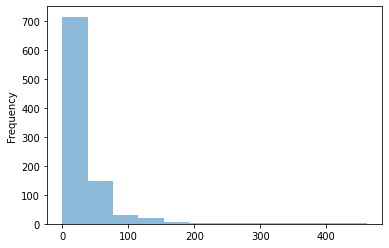

In [40]:
# Total Cases histogram city="sj"
sj_train_y.plot.hist(bins=12, alpha=0.5)

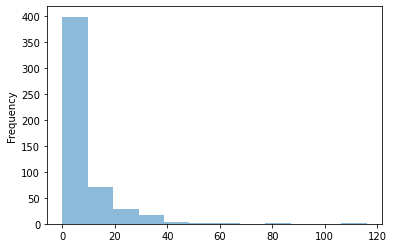

In [41]:
# Total Cases histogram city="iq"
iq_train_y.plot.hist(bins=12, alpha=0.5)

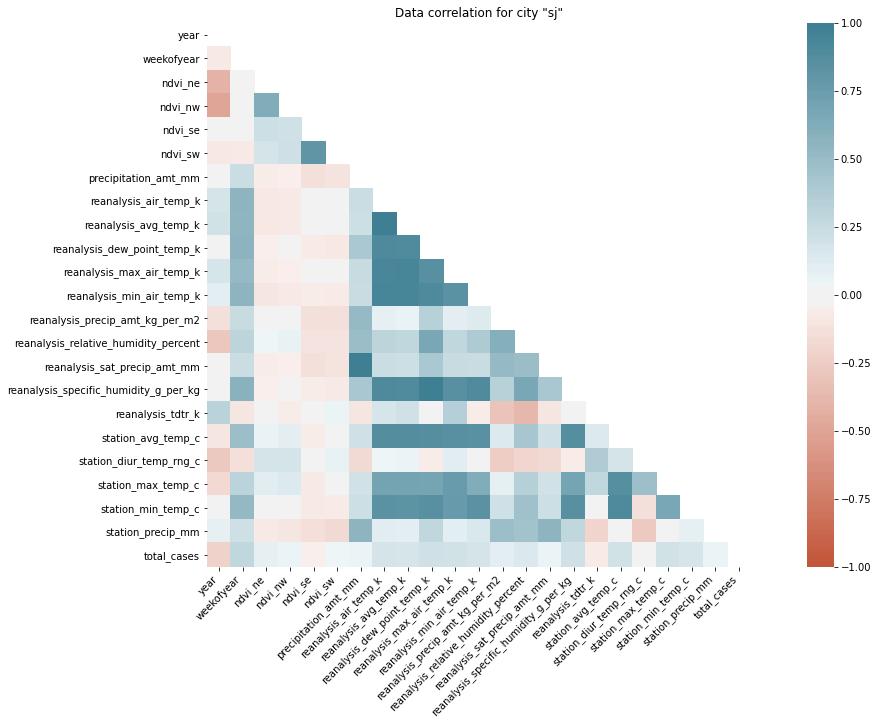

In [126]:
sj_train_x['total_cases'] = sj_train_y
corr = sj_train_x.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    corr, 
     mask=mask, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_title('Data correlation for city "sj"')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Text(0.5, 1.0, 'Correlation with total_cases in "sj"')

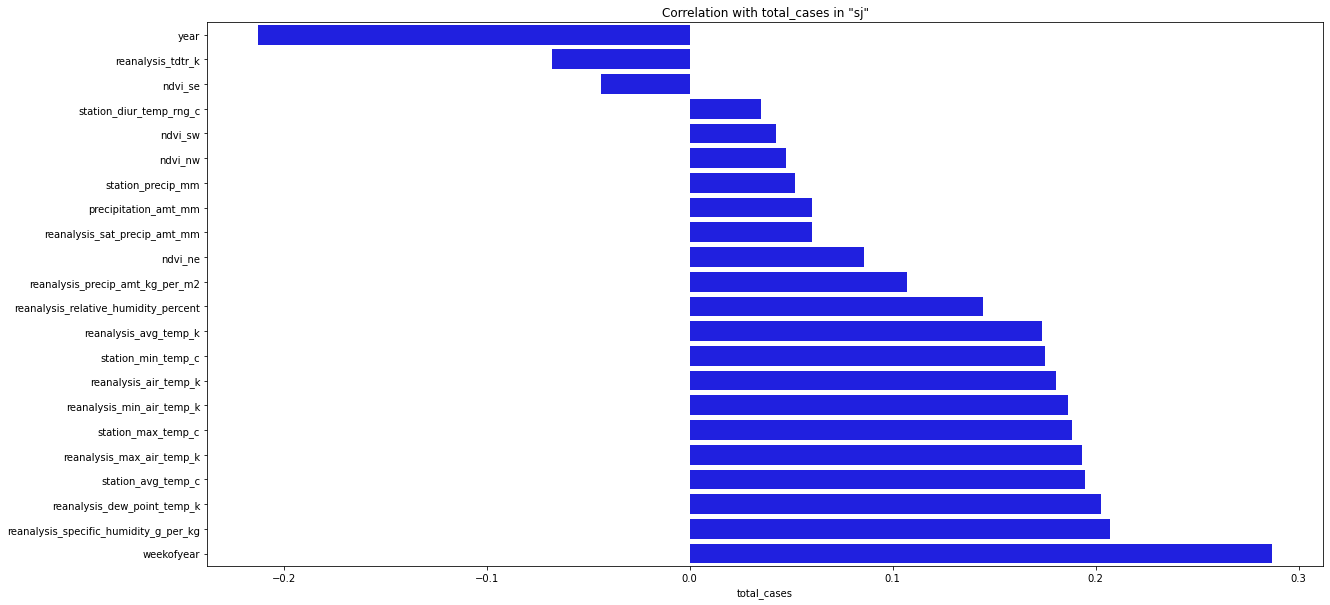

In [127]:
sorted_y = corr.sort_values(by='total_cases', axis=0).drop('total_cases')
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=sorted_y.total_cases, y=sorted_y.index, color="b")
ax.set_title('Correlation with total_cases in "sj"')

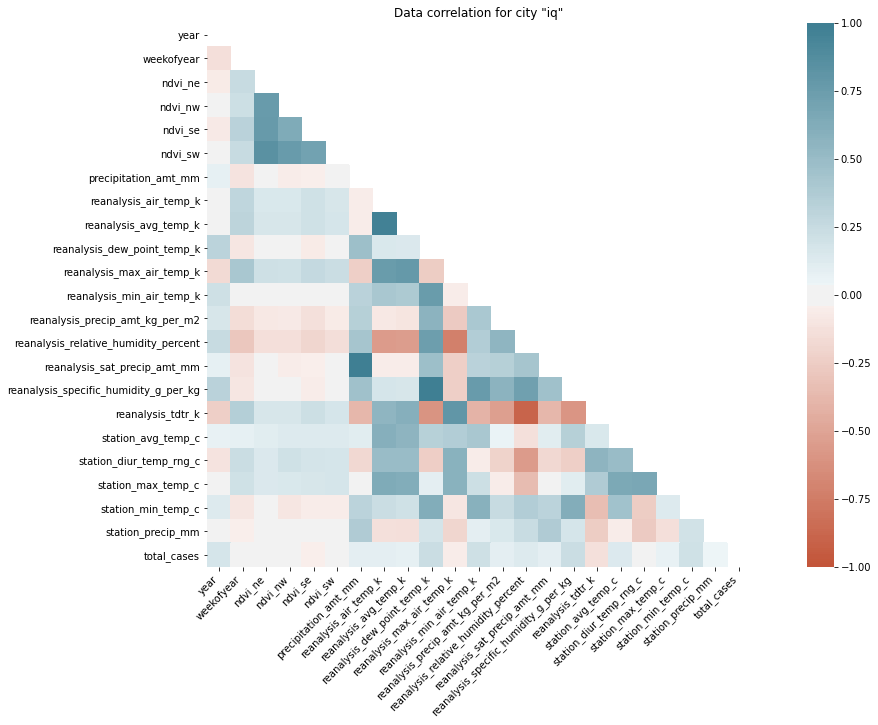

In [128]:
iq_train_x['total_cases'] = iq_train_y
corr = iq_train_x.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    corr, 
     mask=mask, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_title('Data correlation for city "iq"')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Text(0.5, 1.0, 'Correlation with total_cases in "iq"')

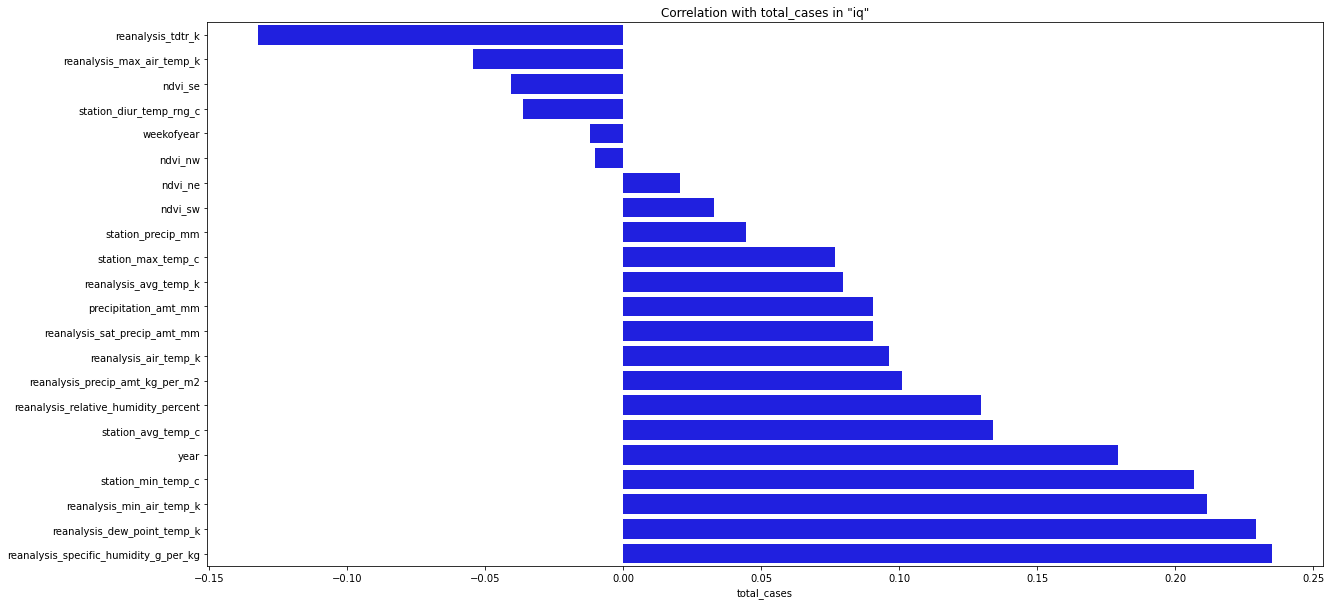

In [129]:
sorted_y = corr.sort_values(by='total_cases', axis=0).drop('total_cases')
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=sorted_y.total_cases, y=sorted_y.index, color="b")
ax.set_title('Correlation with total_cases in "iq"')